In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()

        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)#1 layer   #RGB so *3
        self.fc2 = nn.Linear(in_features=24, out_features=32)#2 layer
        self.out = nn.Linear(in_features=32, out_features=2)# Output layer , 2 outputs Left or Right

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [4]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

e = Experience(2,3,1,4) 
e

Experience(state=2, action=3, next_state=1, reward=4)

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity #Max Memory
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience) #Append Experiences
        else:
            self.memory[self.push_count % self.capacity] = experience #% is used to grab remainder after division
        self.push_count += 1
        
    def sample(self, batch_size): #sample random batch from replay memory
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size): #to ensure we can provide the required batchsize and there is sufficient experiences
        return len(self.memory) >= batch_size

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay): 
        self.start = start #initial learning rate
        self.end = end #max/min learning rate
        self.decay = decay #learning rate rate of change
        
    def get_exploration_rate(self, current_step): #Explore more at start, Exploit more at end
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [7]:
class Agent(): #Decides best action to take
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy #Epsilon Greedy Strategy
        self.num_actions = num_actions
        self.device = device #CPU OR GPU
    def select_action(self, state, policy_net): 
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1 #Get rate and add to step

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore ,return action as tensor    
        else:
            with torch.no_grad(): #to get gradients
                return policy_net(state).argmax(dim=1).to(self.device) # exploit 
            #get current state, get maximum value Q-value for action 

In [8]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0', render_mode="rgb_array").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self):
        return self.env.render()
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):        
        _, reward, self.done, _, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render().transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

c:\Users\Rahul Mitra\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


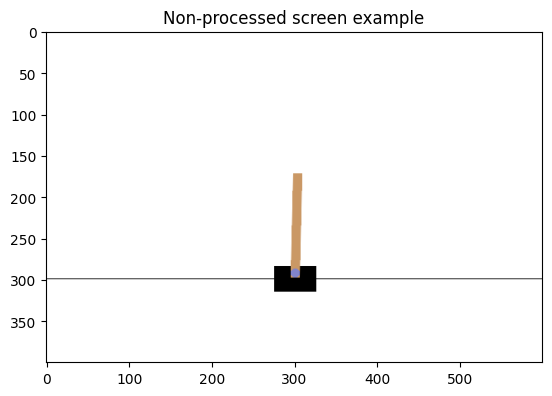

In [9]:
#Non-Processed Screen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render()

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

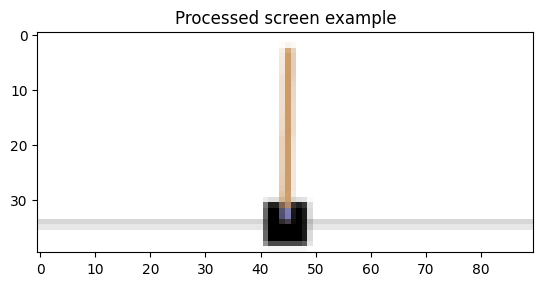

In [10]:
#Processed Screen
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show() #this is the difference between 2 states

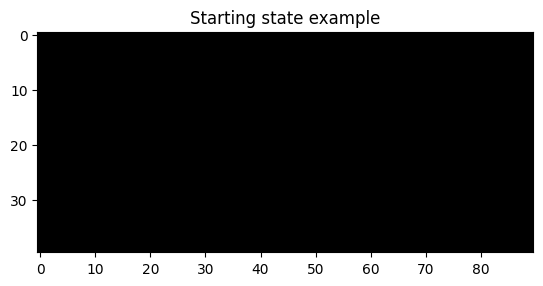

In [11]:
#Starting State
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


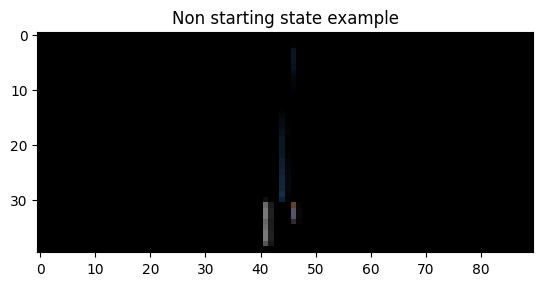

In [12]:
#Non-Starting State
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

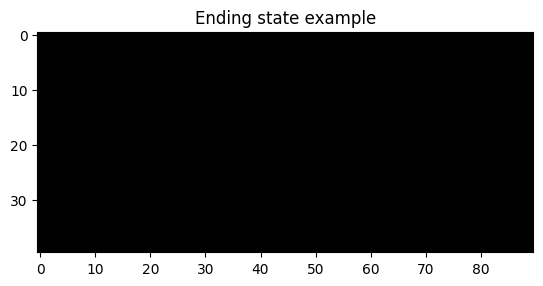

In [13]:
#Ending state
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

In [14]:
def get_moving_average(values, period):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
    else:
        moving_avg = torch.zeros(len(values))
    return moving_avg.numpy()

In [15]:
get_moving_average(np.random.rand(300), 100)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [16]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(values, moving_avg_period)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "last episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

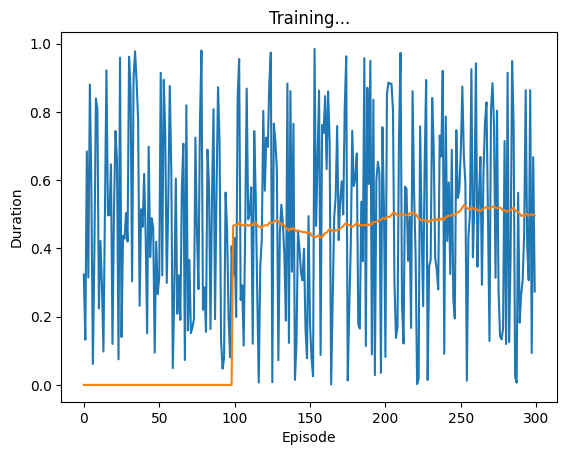

Episode 300 
 100 last episode moving avg: 0.49598736


In [17]:
plot(np.random.rand(300), 100)

In [18]:
batch_size = 256
gamma = 0.999 #Discount factor
eps_start = 1 #epsilon max explore
eps_end = 0.01 #epsilon max exploit
eps_decay = 0.001 #epsilon, exploit or explore
target_update = 10 #After 10 iteration update target network
memory_size = 100000 #Replay Memory
lr = 0.001 #Learning Rate
num_episodes = 1000 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

In [20]:
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [21]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

In [22]:
# Check network structure
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [23]:
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

In [24]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [25]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod #don't have to initiate class to call method
    def get_current(policy_net, states, actions): #gathering q-values
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1)) #passing state through policy network returns 2 q values for actions and return it after gathering
    
    @staticmethod        
    def get_next(target_net, next_states):     
        #First we identify each state if its a blanck screen or not           
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool) #all values 0
        non_final_state_locations = (final_state_locations == False) #negative of final states
        #next we get the Q-values from the non final states, or states where the cartpole is running
        non_final_states = next_states[non_final_state_locations] 
        batch_size = next_states.shape[0] #next state
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()

        return values #return q-value

In [26]:
episode_duration = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state() #S
    for timestep in count():
        action = agent.select_action(state, policy_net) #a
        reward = em.take_action(action) #R
        next_state = em.get_state() #S'

        memory.push(Experience(state, action, reward, next_state)) #Replay Mem
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size) #random sample
            states, actions, rewards, next_states = extract_tensors(experiences)
            #calculate loss and update Q value
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_state)
            target_q_values = (next_q_values * gamma) +rewards

            #Back Prop
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(-1))
            optimizer.zero_grad() #resteart grad before implementing loss
            loss.backward() #calculate gradients/ weights
            optimizer.step()

        if em.done:
            episode_duration.append(timestep)
            plot(episode_duration, 100)
            break

    if episode % target_update == 0: #update target netwrok
        target_net.load_state_dict(policy_net.state_dict())

em.close()

KeyboardInterrupt: 